<a href="https://colab.research.google.com/github/nan-hk/-motion-artifacts/blob/master/UNet_3D_segmentation_net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
from google.colab import drive
import os

drive.mount('/content/drive/')

zip_ref = zipfile.ZipFile("/content/drive/My Drive/data_3D.zip", 'r')
zip_ref.extractall("/content/tmp")
zip_ref.close()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume


In [3]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(), "/content/tmp/data_3D/GT", x)
    for x in os.listdir("/content/tmp/data_3D/GT")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(), "/content/tmp/data_3D/Label", x)
    for x in os.listdir("/content/tmp/data_3D/Label")
]

test_paths = [
    os.path.join(os.getcwd(), "/content/tmp/data_3D/test/raw", x)
    for x in os.listdir("/content/tmp/data_3D/test/raw")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(test_paths)))

CT scans with normal lung tissue: 202
CT scans with abnormal lung tissue: 202
CT scans with abnormal lung tissue: 4


In [4]:
import numpy as np
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])
test_scans = np.array([process_scan(path) for path in test_paths])

# Split data in the ratio 70-30 for training and validation.
image_train = np.array((normal_scans[:101]))
mask_train = np.array((abnormal_scans[:101]))
image_val = np.array((normal_scans[101:]))
mask_val = np.array(abnormal_scans[101:])
test = np.array(test_scans[:4])
print(
    "Number of samples in train and validation are %d and %d."
    % (image_train.shape[0], mask_val.shape[0])
)

Number of samples in train and validation are 101 and 101.


In [5]:
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from scipy import ndimage



@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [6]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((image_train, mask_train))
validation_loader = tf.data.Dataset.from_tensor_slices((image_val, mask_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(image_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(image_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

Dimension of the CT scan is: (128, 128, 64, 1)


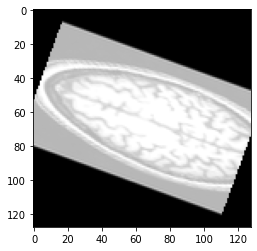

In [7]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")


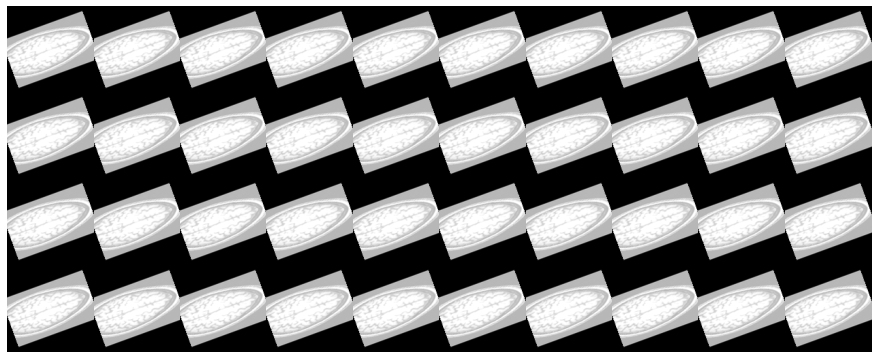

In [8]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 128, 128, image[:, :, :40])

Dimension of the CT scan is: (128, 128, 64, 1)


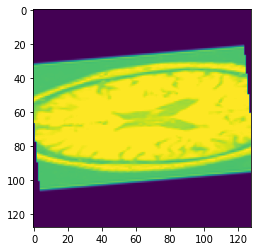

In [9]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]))

In [10]:
from keras.models import Model
from keras.layers import Input, concatenate, Conv3D, MaxPooling3D, Conv3DTranspose, AveragePooling3D, ZeroPadding3D

def get_unet(width, height, depth):
    inputs = Input((width, height, depth, 1))
    conv11 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
    conc11 = concatenate([inputs, conv11], axis=4)
    conv12 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc11)
    conc12 = concatenate([inputs, conv12], axis=4)
    pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conc12)

    conv21 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
    conc21 = concatenate([pool1, conv21], axis=4)
    conv22 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc21)
    conc22 = concatenate([pool1, conv22], axis=4)
    pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conc22)

    conv31 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)
    conc31 = concatenate([pool2, conv31], axis=4)
    conv32 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc31)
    conc32 = concatenate([pool2, conv32], axis=4)
    pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conc32)

    conv41 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(pool3)
    conc41 = concatenate([pool3, conv41], axis=4)
    conv42 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc41)
    conc42 = concatenate([pool3, conv42], axis=4)
    pool4 = MaxPooling3D(pool_size=(2, 2, 2))(conc42)

    conv51 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(pool4)
    conc51 = concatenate([pool4, conv51], axis=4)
    conv52 = Conv3D(512, (3, 3, 3), activation='relu', padding='same')(conc51)
    conc52 = concatenate([pool4, conv52], axis=4)

    up6 = concatenate([Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc52), conc42], axis=4)
    conv61 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(up6)
    conc61 = concatenate([up6, conv61], axis=4)
    conv62 = Conv3D(256, (3, 3, 3), activation='relu', padding='same')(conc61)
    conc62 = concatenate([up6, conv62], axis=4)

    up7 = concatenate([Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc62), conv32], axis=4)
    conv71 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(up7)
    conc71 = concatenate([up7, conv71], axis=4)
    conv72 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(conc71)
    conc72 = concatenate([up7, conv72], axis=4)

    up8 = concatenate([Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc72), conv22], axis=4)
    conv81 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(up8)
    conc81 = concatenate([up8, conv81], axis=4)
    conv82 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conc81)
    conc82 = concatenate([up8, conv82], axis=4)

    up9 = concatenate([Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(conc82), conv12], axis=4)
    conv91 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(up9)
    conc91 = concatenate([up9, conv91], axis=4)
    conv92 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(conc91)
    conc92 = concatenate([up9, conv92], axis=4)

    conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conc92)

    model = Model(inputs=[inputs], outputs=[conv10], name="3dcnn")

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model


# Build model.
model = get_unet(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  896         ['input_1[0][0]']                
                                , 32)                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 128, 128, 64  0           ['input_1[0][0]',                
                                , 33)                             'conv3d[0][0]']             

In [17]:
from keras.callbacks import ModelCheckpoint, CSVLogger

def train():
    print('-'*30)
    print('Loading and preprocessing train data...')
    print('-'*30)

    print('-'*30)
    print('Creating and compiling model...')
    print('-'*30)
    model = get_unet(width=128, height=128, depth=64)
    weight_dir = '/content/tmp/data_3D'
    model_checkpoint = ModelCheckpoint("3d_image_segmentation.h5", save_best_only=True)

    log_dir = '/content/tmp/data_3D'
    csv_logger = CSVLogger("data_3D.csv", separator=',', append=False)

    print('-'*30)
    print('Fitting model...')
    print('-'*30)

    model.fit(train_dataset, batch_size=1, epochs=5, verbose=1, shuffle=True, callbacks=[model_checkpoint, csv_logger])

    print('-'*30)
    print('Training finished')
    print('-'*30)

train()

------------------------------
Loading and preprocessing train data...
------------------------------
------------------------------
Creating and compiling model...
------------------------------
------------------------------
Fitting model...
------------------------------
Epoch 1/5
51/51 [==============================] - 306s 6s/step - loss: 0.4475 - accuracy: 0.4621
Epoch 2/5
51/51 [==============================] - 299s 6s/step - loss: 0.2354 - accuracy: 0.5065
Epoch 3/5
51/51 [==============================] - 299s 6s/step - loss: 0.2232 - accuracy: 0.5069
Epoch 4/5
51/51 [==============================] - 300s 6s/step - loss: 0.2253 - accuracy: 0.5069
Epoch 5/5
51/51 [==============================] - 299s 6s/step - loss: 0.2231 - accuracy: 0.5069
------------------------------
Training finished
------------------------------


In [18]:
def test_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

test_loader = tf.data.Dataset.from_tensor_slices((test))

batch_size = 2
# Augment the on the fly during training.
test_dataset = (
    train_loader.shuffle(len(test))
    .map(test_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)


In [32]:
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

import tensorflow as tf

image = process_scan(test_paths[0])
image = np.expand_dims(image, axis=0)
print(image.shape)
output = model.predict(image)

(1, 128, 128, 64)


In [45]:
print(output.shape)
converted_array = np.array(output, dtype=np.float32)
converted_squeeze = np.squeeze(converted_array, axis=0)
squeese = np.squeeze(converted_squeeze, axis=3)
print(squeese.shape)

(1, 128, 128, 64, 1)
(128, 128, 64)


In [46]:
import nibabel as nib

affine = np.eye(4)
nifti_file = nib.Nifti1Image(squeese, affine)

nib.save(nifti_file, 'data_3D.nii')

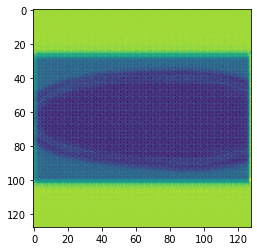

In [48]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

test_load = nib.load('data_3D.nii').get_fdata()
test_load.shape
test = test_load[:,:,12]
plt.imshow(test)
plt.show()